In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Mon Oct 17 18:38:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD

np.random.seed(0)

### Setup and Load dataset

In [ ]:

import pandas as pd
import os
from os.path import exists
import zipfile
import numpy as np

In [ ]:
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# !pip install gdown
# !pip uninstall scikit-surprise

In [ ]:
SEED=42

In [ ]:
!gdown https://drive.google.com/uc?id=1wvQW5W2t5to-_eN0bu3eOqXIqz3NDXKH


Downloading...
From: https://drive.google.com/uc?id=1wvQW5W2t5to-_eN0bu3eOqXIqz3NDXKH
To: /content/retailrocket.zip
100% 305M/305M [00:00<00:00, 346MB/s]


In [ ]:
!unzip -o "retailrocket.zip"  -d  "/content"

Archive:  retailrocket.zip
  inflating: /content/category_tree.csv  
  inflating: /content/events.csv     
  inflating: /content/item_properties_part1.csv  
  inflating: /content/item_properties_part2.csv  


# Data Preprocessing

In [ ]:
rating_df =pd.read_csv('events.csv')


In [ ]:
rating_df.rename(columns = {str("timestamp"):"time"}, inplace = True)
rating_df.rename(columns = {str("visitorid"):"userID"}, inplace = True)
rating_df.rename(columns = {str("itemid"):"itemID"}, inplace = True)

In [ ]:
rating_df.event.unique()

array(['view', 'addtocart', 'transaction'], dtype=object)

In [ ]:
data_w = rating_df.copy()

conditions = [
    data_w['event'] == 'view',
    data_w['event'] == 'addtocart',
    data_w['event'] == 'transaction'
]

choices = [1, 2, 3]

data_w['Weight'] = np.select(conditions, choices, default='black')

# Convert to numeric type.
data_w['Weight'] = pd.to_numeric(data_w['Weight'])

In [ ]:
data_wcount = data_w.groupby(['userID', 'itemID'])['Weight'].sum().reset_index()
data_wcount.columns = ['userID', 'itemID', 'rating']

In [ ]:
rating_df=data_wcount

In [ ]:
sar_df =pd.read_csv('events.csv')


In [ ]:
sar_df.rename(columns = {str("timestamp"):"time"}, inplace = True)
sar_df.rename(columns = {str("visitorid"):"userID"}, inplace = True)
sar_df.rename(columns = {str("itemid"):"itemID"}, inplace = True)

In [ ]:
data_w = sar_df.copy()

conditions = [
    data_w['event'] == 'view',
    data_w['event'] == 'addtocart',
    data_w['event'] == 'transaction'
]

choices = [1, 2, 3]

data_w['Weight'] = np.select(conditions, choices, default='black')

# Convert to numeric type.
data_w['Weight'] = pd.to_numeric(data_w['Weight'])

In [ ]:
sar_df=data_w

In [ ]:
sar_df.rename(columns = {str("Weight"):"rating"}, inplace = True)

In [ ]:
sar_df=sar_df[['userID','itemID','time','rating']]

In [ ]:
sar_df=sar_df.sort_values(by=['userID','time'],ascending=[False,False])

In [ ]:
sar_df=sar_df.groupby(['userID','itemID']).head(1)


# Sparsity

In [ ]:
from scipy.sparse import csr_matrix
def checkSparsity(main_df):
   
    # pivot_df = main_df.pivot_table(
    #     index='itemID',
    #     columns='userID',
    #     values='rating'
    # )
    totalUsers=main_df.userID.unique().shape[0]
    totalitems= main_df.itemID.unique().shape[0]
    total=totalUsers*totalitems
    totalreconds=main_df.shape[0]
    sparsity=(total-totalreconds)/total
    return sparsity

In [ ]:
rating1_df=rating_df.copy()

In [ ]:

y = rating1_df.groupby('itemID').count()['rating']>=10
ids = y[y].index
rating1_df = rating1_df[rating1_df['itemID'].isin(ids)]
y = rating1_df.groupby('userID').count()['rating']>=10
ids = y[y].index
rating1_df = rating1_df[rating1_df['userID'].isin(ids)]
rating1_df.shape

(168517, 3)

In [ ]:

sparsity1=checkSparsity(rating1_df)
sparsity1

0.9991598642226277

In [ ]:
rating2_df=rating_df.copy()

In [ ]:

y = rating2_df.groupby('itemID').count()['rating']>=30
ids = y[y].index
rating2_df = rating2_df[rating2_df['itemID'].isin(ids)]
y = rating2_df.groupby('userID').count()['rating']>=30
ids = y[y].index
rating2_df = rating2_df[rating2_df['userID'].isin(ids)]
rating2_df.shape

(47186, 3)

In [ ]:

sparsity2=checkSparsity(rating2_df)
sparsity2

0.9883489488102896

In [ ]:
rating3_df=rating_df.copy()

In [ ]:

y = rating3_df.groupby('itemID').count()['rating']>=50
ids = y[y].index
rating3_df = rating3_df[rating3_df['itemID'].isin(ids)]
y = rating3_df.groupby('userID').count()['rating']>=30
ids = y[y].index
rating3_df = rating3_df[rating3_df['userID'].isin(ids)]
rating3_df.shape

(30343, 3)

In [ ]:

sparsity3=checkSparsity(rating3_df)
sparsity3

0.9798907820877322

In [ ]:
sar1_df=sar_df.copy()

In [ ]:

y = sar1_df.groupby('itemID').count()['rating']>=30
ids = y[y].index
sar1_df = sar1_df[sar1_df['itemID'].isin(ids)]
y = sar1_df.groupby('userID').count()['rating']>=30
ids = y[y].index
sar1_df = sar1_df[sar1_df['userID'].isin(ids)]
sar1_df.shape

(47186, 4)

In [ ]:
sar2_df=sar_df.copy()

In [ ]:

y = sar2_df.groupby('itemID').count()['rating']>=10
ids = y[y].index
sar2_df = sar2_df[sar2_df['itemID'].isin(ids)]
y = sar2_df.groupby('userID').count()['rating']>=10
ids = y[y].index
sar2_df = sar2_df[sar2_df['userID'].isin(ids)]
sar2_df.shape

(168517, 4)

In [ ]:

sparsity_sar1=checkSparsity(sar1_df)
sparsity_sar1

0.9883489488102896

In [ ]:

sparsity_sar2=checkSparsity(sar2_df)
sparsity_sar2

0.9991598642226277

In [ ]:
summary_df=pd.DataFrame(columns=['Dataset','Algorithm','Sparsity','Recall@K','Precision@k'])

In [ ]:
userID="userID"
itemID="itemID"
score="rating"
timestamp=None

# Factorization machine

In [ ]:
!pip install rankfm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 145 kB 4.1 MB/s 
  Created wheel for rankfm: filename=rankfm-0.2.5-cp37-cp37m-linux_x86_64.whl size=386163 sha256=2c3f9708bd4ba3a08bbf1b7fd83cc407d4367c162323d3319527a0255d1701e6
  Stored in directory: /root/.cache/pip/wheels/99/5f/9d/caa74d8a3cad3dcc3ed9e02d27e7bc18d0ccd1dd5ed1fcdb99
Successfully built rankfm


In [ ]:
from rankfm.rankfm import RankFM
from rankfm.evaluation import hit_rate, reciprocal_rank, discounted_cumulative_gain, precision, recall, diversity
from datetime import datetime


In [ ]:
EPOCHS=50
MAX_SAMPLES=30
ALPHA=0.01
SIGMA=0.1
LR=0.10
LOSS='warp'
FACTORS=20

In [ ]:
FMUSER='user_id'
FMITEM='item_id'

In [ ]:
class FactMachineExplicit:
  def setup(self,fm_df):
    self.valid_recommendations= None
    fm_df['random'] = np.random.random(size=len(fm_df))
    test_pct = 0.25
    train_mask = fm_df['random'] <  (1 - test_pct)
    valid_mask = fm_df['random'] >= (1 - test_pct)
    self.interactions_train = fm_df[train_mask].groupby([FMUSER, FMITEM]).mean().reset_index()
    self.interactions_valid = fm_df[valid_mask].groupby([FMUSER, FMITEM]).mean().reset_index()
 
   
    self.weight_train = np.log2(self.interactions_train[RATING] + 1)
    self.weight_valid =  np.log2(self.interactions_valid[RATING] + 1)

    self.interactions_train=self.interactions_train[[FMUSER, FMITEM]]
    self.interactions_valid=self.interactions_valid[[FMUSER, FMITEM]]
    self.train_users = np.sort(self.interactions_train[FMUSER].unique())
    self.valid_users = np.sort(self.interactions_valid[FMUSER].unique())
    cold_start_users = set(self.valid_users) - set(self.train_users)
    self.train_items = np.sort(self.interactions_train[FMITEM].unique())
    self.valid_items = np.sort(self.interactions_valid[FMITEM].unique())
    cold_start_items = set(self.valid_items) - set(self.train_items)
    
    print("train shape: {}".format(self.interactions_train.shape))
    print("valid shape: {}".format(self.interactions_valid.shape))

    print("train users: {}".format(len(self.train_users)))
    print("valid users: {}".format(len(self.valid_users)))
    print("cold-start users: {}".format(cold_start_users))

    print("train items: {}".format(len(self.train_items)))
    print("valid items: {}".format(len(self.valid_items)))
    print("cold-start items: {}".format(cold_start_items))
    self.user_features_train=None
    self.user_features_valid=None
    self.item_features_train=None
    self.item_features_valid=None

     
    self.model = RankFM(factors=FACTORS, loss=LOSS, max_samples=MAX_SAMPLES, alpha=ALPHA, sigma=SIGMA, learning_rate=LR, learning_schedule='invscaling')

  def train(self):
    #print(self.item_features_train.columns[0])
    before= datetime.now()
    # if self.item_features_train is not None and self.user_features_train is not None:
    #   self.model.fit(self.interactions_train,item_features=self.item_features_train,user_features=self.user_features_train, epochs=20, verbose=True)
    # if self.item_features_train is  None and self.user_features_train is not None:
    #   self.model.fit(self.interactions_train,user_features=self.user_features_train, epochs=EPOCHS, verbose=True)
 
    # if self.item_features_train is not None and self.user_features_train is  None:
    #   self.model.fit(self.interactions_train,sample_weight=self.weight_train,item_features=self.item_features_train, epochs=EPOCHS, verbose=True)
    # if self.item_features_train is  None and self.user_features_train is  None:
    self.model.fit(self.interactions_train,sample_weight=self.weight_train, epochs=EPOCHS, verbose=False)
 
    after= datetime.now()
    self.duration = after-before 
  def evaluate(self,k):
    if self.valid_recommendations is None:
      self.valid_recommendations = self.model.recommend(self.valid_users, n_items=10, filter_previous=True, cold_start='nan')
    self.model_hit_rate = hit_rate(self.model, self.interactions_valid, k=k)
    self.model_reciprocal_rank = reciprocal_rank(self.model, self.interactions_valid, k=k)
    self.model_dcg = discounted_cumulative_gain(self.model, self.interactions_valid, k=k)
    self.model_precision = precision(self.model, self.interactions_valid, k=k)
    self.model_recall = recall(self.model, self.interactions_valid, k=k)
    print("hit_rate: {:.3f}".format(self.model_hit_rate))
    print("reciprocal_rank: {:.3f}".format(self.model_reciprocal_rank))
    print("dcg: {:.3f}".format(self.model_dcg, 3))
    print("precision: {:.3f}".format(self.model_precision))
    print("recall: {:.3f}".format(self.model_recall))
    return self.model_recall,self.model_precision,self.model_hit_rate,self.duration.total_seconds()



In [ ]:
USER="userID"
ITEM="itemID"
RATING="rating"
TOP_K=20

In [ ]:
fm_df=rating1_df.copy()
FMUSER='user_id'
FMITEM='item_id'
fm_df.rename(columns = {USER:FMUSER, ITEM:FMITEM}, inplace = True)
fm_df=fm_df[[FMUSER,FMITEM,RATING]]
fm=FactMachineExplicit()
fm.setup(fm_df)
fm.train()
fm_testrecall,fm_testprecesion,hit,fm_duration=fm.evaluate(TOP_K)



train shape: (126153, 2)
valid shape: (42364, 2)
train users: 6717
valid users: 6550
cold-start users: set()
train items: 27863
valid items: 18498
cold-start items: {8193, 229378, 401411, 212993, 253956, 294918, 122890, 229388, 409612, 49167, 90130, 19, 180248, 8218, 221212, 16420, 131111, 57386, 278576, 270386, 213043, 385077, 139324, 458813, 90183, 270410, 147530, 401488, 458836, 229470, 106591, 335969, 106595, 426085, 335974, 41063, 434291, 155765, 344184, 24698, 327810, 213129, 327819, 131217, 221333, 352410, 49307, 221343, 278689, 417954, 32934, 180406, 352442, 426171, 327870, 41150, 336063, 270529, 204999, 327884, 319692, 16594, 393427, 172244, 8411, 262374, 139506, 205044, 442612, 254200, 459002, 434429, 221443, 434454, 459040, 24871, 305, 295218, 8497, 303412, 147763, 442674, 311603, 319797, 74041, 213307, 393533, 180544, 254278, 393547, 418127, 33105, 41297, 237913, 254297, 213354, 434539, 213358, 401778, 221558, 139639, 24956, 24960, 246147, 409991, 237960, 229772, 393612, 24

In [ ]:
df2 = {'Dataset':"Retail Racket",'Algorithm':"Factorization Machine",'Sparsity':sparsity1,'Recall@K':fm_testrecall,'Precision@k':fm_testprecesion,'HitRate@k':hit}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
fm_df=rating2_df.copy()
FMUSER='user_id'
FMITEM='item_id'
fm_df.rename(columns = {USER:FMUSER, ITEM:FMITEM}, inplace = True)
fm_df=fm_df[[FMUSER,FMITEM,RATING]]
fm=FactMachineExplicit()
fm.setup(fm_df)
fm.train()
fm_testrecall,fm_testprecesion,hit,fm_duration=fm.evaluate(TOP_K)



train shape: (35431, 2)
valid shape: (11755, 2)
train users: 395
valid users: 395
cold-start users: set()
train items: 9537
valid items: 6086
cold-start items: {167940, 438277, 301063, 395273, 450571, 243733, 288795, 104476, 241694, 358438, 417832, 227368, 446507, 77874, 256053, 213051, 272446, 137279, 14398, 69697, 190530, 69699, 53316, 26694, 460873, 28747, 165966, 147534, 182351, 67666, 294995, 202835, 350291, 143446, 36958, 321631, 196704, 145504, 14434, 34915, 114786, 170085, 413794, 57445, 452711, 374892, 118894, 264306, 444533, 114806, 106615, 333945, 440441, 342143, 176256, 131201, 297097, 147595, 366732, 356498, 37011, 123032, 96409, 374938, 163998, 239775, 403619, 450726, 88231, 80040, 63656, 196780, 188589, 403630, 114866, 334004, 49339, 311484, 196797, 264384, 420033, 63682, 448708, 18630, 415948, 51405, 12495, 133330, 323794, 418007, 428249, 258266, 28893, 139487, 55523, 76005, 342247, 461032, 149735, 43242, 299245, 372973, 92400, 106741, 166138, 219389, 307455, 434432, 78

In [ ]:
df2 = {'Dataset':"Retail Racket",'Algorithm':"Factorization Machine",'Sparsity':sparsity2,'Recall@K':fm_testrecall,'Precision@k':fm_testprecesion,'HitRate@k':hit}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
fm_df=rating3_df.copy()
FMUSER='user_id'
FMITEM='item_id'
fm_df.rename(columns = {USER:FMUSER, ITEM:FMITEM}, inplace = True)
fm_df=fm_df[[FMUSER,FMITEM,RATING]]
fm=FactMachineExplicit()
fm.setup(fm_df)
fm.train()
fm_testrecall,fm_testprecesion,hit,fm_duration=fm.evaluate(TOP_K)



train shape: (22923, 2)
valid shape: (7420, 2)
train users: 265
valid users: 265
cold-start users: set()
train items: 5370
valid items: 3602
cold-start items: {194562, 438277, 223242, 346137, 325670, 426026, 389172, 260152, 213051, 14398, 53316, 352328, 411723, 350291, 133209, 327771, 36977, 63603, 401523, 454771, 135289, 307322, 256124, 114814, 67719, 147595, 442511, 157846, 381080, 143514, 71843, 403630, 49339, 444603, 264384, 374981, 192710, 28893, 223465, 96489, 14579, 205044, 145665, 395522, 217347, 215308, 295191, 31004, 22814, 133415, 301354, 368947, 454972, 221501, 299347, 287061, 395611, 147807, 252262, 303473, 92533, 262522, 43391, 399748, 311694, 10659, 61859, 170403, 47526, 342443, 133549, 135609, 328122, 16832, 174529, 55758, 344527, 43472, 205274, 285148, 311774, 203231, 260579, 455141, 440807, 203248, 268784, 315900, 385550, 180768, 154154, 307755, 211503, 432691, 426566, 205387, 453235, 305782, 412280, 408189, 107135, 391823, 164498, 432793, 107162, 70323, 15032, 393918

In [ ]:
df2 = {'Dataset':"Retail Racket",'Algorithm':"Factorization Machine",'Sparsity':sparsity3,'Recall@K':fm_testrecall,'Precision@k':fm_testprecesion,'HitRate@k':hit}
summary_df = summary_df.append(df2, ignore_index = True)

# RBM

In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 339 kB 4.3 MB/s 
     |████████████████████████████████| 5.3 MB 70.7 MB/s 
     |████████████████████████████████| 12.4 MB 53.2 MB/s 
     |████████████████████████████████| 120 kB 71.9 MB/s 
     |████████████████████████████████| 61 kB 8.9 MB/s 
     |████████████████████████████████| 310 kB 88.3 MB/s 
     |████████████████████████████████| 355 kB 67.6 MB/s 
     |████████████████████████████████| 11.8 MB 31.6 MB/s 
     |████████████████████████████████| 636 kB 69.9 MB/s 
     |████████████████████████████████| 395 kB 83.7 MB/s 
     |████████████████████████████████| 7.6 MB 63.0 MB/s 
     |████████████████████████████████| 163 kB 92.5 MB/s 
  Created wheel for lightfm: filename=lightfm-1.16-cp37-cp37m-linux_x86_64.whl size=705368 sha256=21ed951f8bd162fce1150d5b742c6b4f450c5389c95ae2653de3e45e169e31bd
  Stored in directory: /root/.cache/pip/whe

In [ ]:

from recommenders.datasets.python_splitters import python_random_split,  python_stratified_split

from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED


In [ ]:
import torch
import cornac

In [ ]:

from recommenders.models.rbm.rbm import RBM
from recommenders.datasets.python_splitters import numpy_stratified_split
from recommenders.datasets.sparse import AffinityMatrix
from recommenders.datasets import movielens
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.timer import Timer
from recommenders.utils.plot import line_graph

In [ ]:
rating_df=rating2_df.copy()

In [ ]:
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [ ]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1

In [ ]:
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)

In [ ]:
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# rating_df[['rating']] = scaler.fit_transform(rating_df[['rating']])

Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


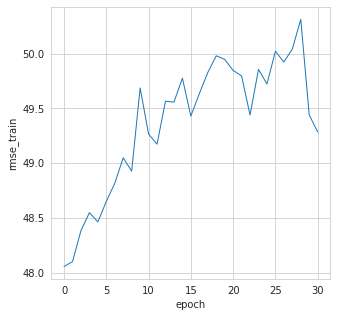

In [ ]:
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df =rating_df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()
Xtr, Xtst = numpy_stratified_split(X)
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.8,
    with_metrics=True
)
# Model Fit
model.fit(Xtr)

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [ ]:
top_k =  model.recommend_k_items(Xtst)
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
eval_precision = precision_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= 20)

In [ ]:
eval_recall = recall_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= 20)


In [ ]:
df2 = {'Dataset':"Retail Racket",'Algorithm':"RBM",'Sparsity':sparsity2,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
rating_df=rating3_df.copy()

In [ ]:
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [ ]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1

In [ ]:
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)

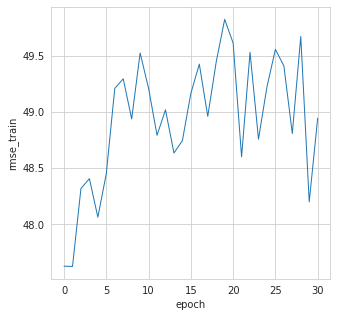

In [ ]:
header = {
        "col_user": "userID",
        "col_item": "itemID",
        "col_rating": "rating",
    }

#instantiate the sparse matrix generation  
am = AffinityMatrix(df =rating_df, **header)

#obtain the sparse matrix 
X, _, _ = am.gen_affinity_matrix()
Xtr, Xtst = numpy_stratified_split(X)
#First we initialize the model class
model = RBM(
    possible_ratings=np.setdiff1d(np.unique(Xtr), np.array([0])),
    visible_units=Xtr.shape[1],
    hidden_units=600,
    training_epoch=30,
    minibatch_size=60,
    keep_prob=0.8,
    with_metrics=True
)
# Model Fit
model.fit(Xtr)

# Plot the train RMSE as a function of the epochs
line_graph(values=model.rmse_train, labels='train', x_name='epoch', y_name='rmse_train')


In [ ]:
top_k =  model.recommend_k_items(Xtst)
top_k_df = am.map_back_sparse(top_k, kind = 'prediction')
test_df = am.map_back_sparse(Xtst, kind = 'ratings')

In [ ]:
eval_precision = precision_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                               col_rating="rating", col_prediction="prediction", 
                               relevancy_method="top_k", k= 20)

In [ ]:
eval_recall = recall_at_k(test_df, top_k_df, col_user="userID", col_item="itemID", 
                          col_rating="rating", col_prediction="prediction", 
                          relevancy_method="top_k", k= 20)


In [ ]:
df2 = {'Dataset':"Retail Racket",'Algorithm':"RBM",'Sparsity':sparsity3,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

# Simple Algorithm for Recommendation (SAR)

This is simple recommender algorithm we run this algorithm as firt step if we get following attributes in the dataset - itemid,userid,rating,timestamp

In [ ]:
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.sar import SAR


In [ ]:
USER="userID"
ITEM="itemID"
RATING="rating"
TIMESTAMP="time"
PREDICTION="prediction"
TOP_K=20
SEED=42 

In [ ]:
class SAR_Algo:

  def setup(self,data,col_user=USER,col_item=ITEM,col_rating=RATING,col_time=TIMESTAMP,col_prediction=PREDICTION,ratio=0.8,top_k=TOP_K,seed=SEED):
    self.col_item=col_item
    self.col_user=col_user
    self.top_k=top_k
    self.data=data
    self.col_rating=col_rating
    self.col_prediction=col_prediction
    self.header={
        "col_user": col_user,
        "col_item":col_item,
        "col_rating": col_rating,
        "col_timestamp":col_time,
        "col_prediction": col_prediction
        }
    self.train, self.test = python_stratified_split(self.data, ratio=0.8, col_user=self.header["col_user"], col_item=self.header["col_item"], seed=seed)
    self.model= SAR(
    similarity_type="jaccard", 
    time_decay_coefficient=35, 
    time_now=None, 
    timedecay_formula=True, 
    **self.header
    )
  def trainmodel(self):
    self.model.fit(self.train)
  def prediction(self):
    self.top_k_val = self.model.recommend_k_items(self.test, top_k=self.top_k, remove_seen=True)
    self.top_k_with_titles = (self.top_k_val.join(self.data[[self.col_item]].drop_duplicates().set_index(self.col_item), 
                                on=self.col_item, 
                                how='inner').sort_values(by=[self.col_user, self.col_prediction], ascending=False))

    return self.top_k_with_titles
  def evaluatemodel(self):
    TOP_K=20
    args = [self.test, self.top_k_val]
    kwargs = dict(col_user=self.col_user, 
              col_item=self.col_item, 
              col_rating=self.col_rating, 
              col_prediction=self.col_prediction, 
              relevancy_method='top_k', 
              k=self.top_k)

    eval_map = map_at_k(*args, **kwargs)
    eval_ndcg = ndcg_at_k(*args, **kwargs)
    eval_precision = precision_at_k(*args, **kwargs)
    eval_recall = recall_at_k(*args, **kwargs)


    
    print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')
    return eval_map,eval_precision,eval_recall

In [ ]:
def startSAR(data_df):
  sar=SAR_Algo()
  sar.setup(data=data_df,col_user=USER,col_item=ITEM,col_rating=RATING,col_time=TIMESTAMP,col_prediction=PREDICTION,ratio=0.8,top_k=TOP_K,seed=SEED)
  start = time.time()
  sar.trainmodel()
  end = time.time()
  top_k_data=sar.prediction()
  duration=end-start
  eval_map,eval_precision,eval_recall=sar.evaluatemodel()
  return eval_map,eval_precision,eval_recall,duration

In [ ]:
import time
sar_eval_map=0
sar_eval_precision=0
sar_eval_recall=0
sar_top_k_data=None

    
data_df=sar1_df[[USER,ITEM,RATING,TIMESTAMP]]
    
eval_map,eval_precision,eval_recall,duration=startSAR(data_df)
   

Model:
Top K:		 20
MAP:		 0.008240
NDCG:		 0.033392
Precision@K:	 0.020909
Recall@K:	 0.029124


/usr/local/lib/python3.7/dist-packages/scipy/sparse/data.py:124: RuntimeWarning: invalid value encountered in multiply
  return self._with_data(self.data * other)


In [ ]:
df2 = {'Dataset':"Retail Rocket",'Sparsity':sparsity_sar1,'Algorithm':"SAR",'Precision@k':eval_precision}
summary_df = summary_df.append(df2, ignore_index = True)

#BPR

In [ ]:
import cornac
from recommenders.datasets.python_splitters import python_random_split,python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED



In [ ]:
df=rating3_df.copy()
df=df[['userID','itemID','rating']]
train, test = python_stratified_split(df, 0.75)

train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)
bpr = cornac.models.BPR(
    k=200,
    max_iter=100,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=42
)

bpr.fit(train_set)

all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)

k = 10
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Precision@K:	0.076981
Recall@K:	0.024961


In [ ]:

df2 = {'Dataset':"Retail Rocket",'Algorithm':"BPR",'Sparsity':sparsity3,'Recall@K':eval_recall,'Precision@k': eval_precision }
summary_df = summary_df.append(df2, ignore_index = True)
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k
0,Retail Rocket,BPR,0.979891,0.024961,0.076981


In [ ]:
df=rating2_df.copy()
df=df[['userID','itemID','rating']]
train, test = python_stratified_split(df, 0.75)

train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)
bpr = cornac.models.BPR(
    k=200,
    max_iter=100,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=42
)

bpr.fit(train_set)

all_predictions = predict_ranking(bpr, train, usercol='userID', itemcol='itemID', remove_seen=True)

k = 10
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=k)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=k)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/100 [00:00<?, ?it/s]

Optimization finished!
Precision@K:	0.055696
Recall@K:	0.014488


In [ ]:

df2 = {'Dataset':"Retail Rocket",'Algorithm':"BPR",'Sparsity':sparsity2,'Recall@K':eval_recall,'Precision@k': eval_precision }
summary_df = summary_df.append(df2, ignore_index = True)
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k
0,Retail Rocket,BPR,0.979891,0.024961,0.076981
1,Retail Rocket,BPR,0.988349,0.014488,0.055696


# LightGCN

In [ ]:
!pip install recommenders

In [ ]:
from recommenders.utils.timer import Timer
from recommenders.models.deeprec.models.graphrec.lightgcn import LightGCN
from recommenders.models.deeprec.DataModel.ImplicitCF import ImplicitCF
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_stratified_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.utils.constants import SEED as DEFAULT_SEED
from recommenders.models.deeprec.deeprec_utils import prepare_hparams

In [ ]:
from datetime import datetime


In [ ]:
SEED=42
# top k items to recommend
TOP_K = 10

# Model parameters
EPOCHS = 20
BATCH_SIZE = 256

In [ ]:
def runLighGCN(df_input):
  gcn_df=df_input.copy()
  ct = datetime.now()

  ts = ct.timestamp()
  if timestamp is None:
    gcn_df['timestamp']=ts 
  else:
    gcn_df.rename(columns={timestamp:'timestamp'},inplace=True)
  gcn_df.reset_index()
  gcn_df=gcn_df[['userID','itemID','rating','timestamp']]
  gcn_item_ids = list(set(list(gcn_df.itemID.unique())))
  gcn_user_ids = list(set(list(gcn_df.userID.unique())))
  dict_items = {}
  index = 0
  for ids in sorted(gcn_item_ids):
      dict_items[ids] = index
      index += 1
  dict_users = {}
  index = 0
  for ids in sorted(gcn_user_ids):
      dict_users[ids] = index
      index += 1
  gcn_df["itemID"] = gcn_df["itemID"].map(dict_items)
  gcn_df["userID"] = gcn_df["userID"].map(dict_users)
  gcn_df.reset_index()
  train, test = python_stratified_split(gcn_df, ratio=0.8)
  data = ImplicitCF(train=train, test=test, seed=SEED)
  yaml_file = "param_gcn.yaml"
  hparams = prepare_hparams(yaml_file,
                            n_layers=4,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            learning_rate=0.005,
                            eval_epoch=5,
                            top_k=TOP_K,
                           )
  model = LightGCN(hparams, data, seed=SEED)
  before= datetime.now()
  model.fit()
  after= datetime.now()
  duration=after-before
  topk_scores = model.recommend_k_items(test, top_k=TOP_K, remove_seen=True)
  eval_map = map_at_k(test, topk_scores, k=TOP_K)
  eval_ndcg = ndcg_at_k(test, topk_scores, k=TOP_K)
  eval_precision = precision_at_k(test, topk_scores, k=TOP_K)
  eval_recall = recall_at_k(test, topk_scores, k=TOP_K)
  # Record results with papermill for tests
  print("map"+ str(eval_map))
  print("ndcg"+ str(eval_ndcg))
  print("precision"+ str( eval_precision))
  print("recall"+ str(eval_recall))
  return eval_map,eval_ndcg,eval_precision,eval_recall,duration.total_seconds()

In [ ]:
gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=None,None,None,None,None

gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=runLighGCN(rating3_df)



Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)0.9s: train loss = 0.56003 = (mf)0.55978 + (embed)0.00026
Epoch 2 (train)0.6s: train loss = 0.35422 = (mf)0.35330 + (embed)0.00092
Epoch 3 (train)0.6s: train loss = 0.27654 = (mf)0.27509 + (embed)0.00145
Epoch 4 (train)0.7s: train loss = 0.22435 = (mf)0.22240 + (embed)0.00195
Epoch 5 (train)0.6s + (eval)2.5s: train loss = 0.19751 = (mf)0.19511 + (embed)0.00240, recall = 0.04078, ndcg = 0.10023, precision = 0.08075, map = 0.01951
Epoch 6 (train)0.7s: train loss = 0.16908 = (mf)0.16625 + (embed)0.00284
Epoch 7 (train)0.7s: train loss = 0.15101 = (mf)0.14778 + (embed)0.00323
Epoch 8 (train)0.6s: train loss = 0.13236 = (mf)0.12876 + (embed)0.00361
Epoch 9 (train)0.5s: train loss = 0.12167 = (mf)0.11771 + (embed)0.00396
Epoch 10 (train)0.5s + (eval)0.1s: train loss = 0.11031 = (mf)0.10601 + (embed)0.00430, recall = 0.04563, ndcg = 0.10293, precision = 0.08717, map = 0.01937
Epoch

In [ ]:
df2 = {'Dataset':"Retail Rocket	",'Algorithm':"LightGCN",'Sparsity':sparsity3,'Precision@k':gcn_eval_precision,'Recall@k':gcn_eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=None,None,None,None,None

gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=runLighGCN(rating2_df)



Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)1.1s: train loss = 0.47175 = (mf)0.47134 + (embed)0.00041
Epoch 2 (train)1.1s: train loss = 0.23213 = (mf)0.23083 + (embed)0.00130
Epoch 3 (train)1.0s: train loss = 0.17461 = (mf)0.17273 + (embed)0.00188
Epoch 4 (train)1.1s: train loss = 0.14267 = (mf)0.14032 + (embed)0.00235
Epoch 5 (train)1.1s + (eval)0.2s: train loss = 0.11745 = (mf)0.11468 + (embed)0.00277, recall = 0.03324, ndcg = 0.07639, precision = 0.06532, map = 0.01391
Epoch 6 (train)1.0s: train loss = 0.10225 = (mf)0.09910 + (embed)0.00315
Epoch 7 (train)0.9s: train loss = 0.09026 = (mf)0.08676 + (embed)0.00350
Epoch 8 (train)1.0s: train loss = 0.07727 = (mf)0.07346 + (embed)0.00381
Epoch 9 (train)1.0s: train loss = 0.06923 = (mf)0.06511 + (embed)0.00412
Epoch 10 (train)0.9s + (eval)0.1s: train loss = 0.06305 = (mf)0.05867 + (embed)0.00438, recall = 0.03505, ndcg = 0.08249, precision = 0.07038, map = 0.01504
Epoch

In [ ]:
df2 = {'Dataset':"Retail Rocket	",'Algorithm':"LightGCN",'Sparsity':sparsity2,'Precision@k':gcn_eval_precision,'Recall@k':gcn_eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k,Recall@k
0,Retail Rocket\t,LightGCN,0.979891,NaN,0.085660,0.045443
1,Retail Rocket\t,LightGCN,0.988349,NaN,0.067848,0.037180


In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k,Recall@k
0,Retail Rocket\t,LightGCN,0.979891,NaN,0.085660,0.045443
1,Retail Rocket\t,LightGCN,0.988349,NaN,0.067848,0.037180


In [ ]:
gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=None,None,None,None,None

gcn_eval_map,gcn_eval_ndcg,gcn_eval_precision,gcn_eval_recall,gcn_duration=runLighGCN(rating1_df)



Already create adjacency matrix.
Already normalize adjacency matrix.
Using xavier initialization.
Epoch 1 (train)6.0s: train loss = 0.24314 = (mf)0.24237 + (embed)0.00077
Epoch 2 (train)5.7s: train loss = 0.08267 = (mf)0.08110 + (embed)0.00157
Epoch 3 (train)5.6s: train loss = 0.05913 = (mf)0.05715 + (embed)0.00199
Epoch 4 (train)5.6s: train loss = 0.04641 = (mf)0.04412 + (embed)0.00229
Epoch 5 (train)5.5s + (eval)3.7s: train loss = 0.03888 = (mf)0.03632 + (embed)0.00256, recall = 0.06231, ndcg = 0.04260, precision = 0.02022, map = 0.02107
Epoch 6 (train)5.6s: train loss = 0.03326 = (mf)0.03048 + (embed)0.00279
Epoch 7 (train)5.6s: train loss = 0.02863 = (mf)0.02563 + (embed)0.00301
Epoch 8 (train)5.6s: train loss = 0.02590 = (mf)0.02270 + (embed)0.00320
Epoch 9 (train)5.6s: train loss = 0.02347 = (mf)0.02008 + (embed)0.00339
Epoch 10 (train)5.6s + (eval)3.3s: train loss = 0.02101 = (mf)0.01744 + (embed)0.00356, recall = 0.07847, ndcg = 0.05462, precision = 0.02537, map = 0.02771
Epoch

In [ ]:
df2 = {'Dataset':"Retail Rocket	",'Algorithm':"LightGCN",'Sparsity':sparsity1,'Precision@k':gcn_eval_precision,'Recall@k':gcn_eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k,Recall@k
0,Retail Rocket\t,LightGCN,0.979891,NaN,0.085660,0.045443
1,Retail Rocket\t,LightGCN,0.988349,NaN,0.067848,0.037180
2,Retail Rocket\t,LightGCN,0.999160,NaN,0.032038,0.100151


# BiVAE

In [ ]:

from recommenders.datasets.python_splitters import python_random_split,  python_stratified_split

from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED


In [ ]:
import torch
import cornac

In [ ]:
import pandas as pd
from recommenders.datasets import movielens
from recommenders.datasets.python_splitters import python_random_split
from recommenders.evaluation.python_evaluation import map_at_k, ndcg_at_k, precision_at_k, recall_at_k
from recommenders.models.cornac.cornac_utils import predict_ranking
from recommenders.utils.timer import Timer
from recommenders.utils.constants import SEED

In [ ]:
TOP_K = 10

# Model parameters
LATENT_DIM = 50
ENCODER_DIMS = [100]
ACT_FUNC = "tanh"
LIKELIHOOD = "pois"
NUM_EPOCHS = 500
BATCH_SIZE = 128
LEARNING_RATE = 0.001

In [ ]:
rating_df=rating3_df.copy()

In [ ]:
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)
train, test = python_random_split(rating_df, 0.75)
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

#First we initialize the model class
model = bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)
# Model Fit
model.fit(train_set)

all_predictions = predict_ranking(bivae, train, usercol='userID', itemcol='itemID', remove_seen=True)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/500 [00:00<?, ?it/s]

Precision@K:	0.114394
Recall@K:	0.048609


In [ ]:
df2 = {'Dataset':"Retail Rocket",'Algorithm':"BiVAE",'Sparsity':sparsity3,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k,Recall@k
0,Retail Rocket\t,LightGCN,0.979891,NaN,0.085660,0.045443
1,Retail Rocket\t,LightGCN,0.988349,NaN,0.067848,0.037180
2,Retail Rocket\t,LightGCN,0.999160,NaN,0.032038,0.100151
3,Retail Rocket,BiVAE,0.979891,NaN,0.114394,0.048609


In [ ]:
rating_df=rating2_df.copy()
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)
train, test = python_random_split(rating_df, 0.75)
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

#First we initialize the model class
model = bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)
# Model Fit
model.fit(train_set)

all_predictions = predict_ranking(bivae, train, usercol='userID', itemcol='itemID', remove_seen=True)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/500 [00:00<?, ?it/s]

Precision@K:	0.098481
Recall@K:	0.043590


In [ ]:
df2 = {'Dataset':"Retail Rocket",'Algorithm':"BiVAE",'Sparsity':sparsity2,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k,Recall@k
0,Retail Rocket\t,LightGCN,0.979891,NaN,0.085660,0.045443
1,Retail Rocket\t,LightGCN,0.988349,NaN,0.067848,0.037180
2,Retail Rocket\t,LightGCN,0.999160,NaN,0.032038,0.100151
3,Retail Rocket,BiVAE,0.979891,NaN,0.114394,0.048609
4,Retail Rocket,BiVAE,0.988349,NaN,0.098481,0.043590


In [ ]:
rating_df=rating1_df.copy()
item_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1
dict_items = {}
index = 0
for ids in sorted(item_ids):
    dict_items[ids] = index
    index += 1
rating_df['userID'] = rating_df.userID.map(dict_users)
rating_df['itemID'] = rating_df.itemID.map(dict_items)
train, test = python_random_split(rating_df, 0.75)
train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

#First we initialize the model class
model = bivae = cornac.models.BiVAECF(
    k=LATENT_DIM,
    encoder_structure=ENCODER_DIMS,
    act_fn=ACT_FUNC,
    likelihood=LIKELIHOOD,
    n_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE,
    seed=SEED,
    use_gpu=torch.cuda.is_available(),
    verbose=True
)
# Model Fit
model.fit(train_set)

all_predictions = predict_ranking(bivae, train, usercol='userID', itemcol='itemID', remove_seen=True)
eval_precision = precision_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test, all_predictions, col_prediction='prediction', k=TOP_K)

print(
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')


  0%|          | 0/500 [00:00<?, ?it/s]

In [ ]:
df2 = {'Dataset':"Retail Rocket",'Algorithm':"BiVAE",'Sparsity':sparsity1,'Precision@k':eval_precision,'Recall@k':eval_recall}
summary_df = summary_df.append(df2, ignore_index = True)

In [ ]:
summary_df

# Compare Results

In [ ]:
summary_df

,Dataset,Algorithm,Sparsity,Recall@K,Precision@k,HitRate@k,Recall@k
0,Retail Racket,Factorization Machine,0.999160,0.079127,0.015870,0.232977,NaN
1,Retail Racket,Factorization Machine,0.988349,0.017750,0.013544,0.212658,NaN
2,Retail Racket,Factorization Machine,0.979891,0.012904,0.010943,0.188679,NaN
3,Retail Racket,RBM,0.988349,NaN,0.009620,NaN,0.009536
4,Retail Racket,RBM,0.979891,NaN,0.019623,NaN,0.016930
5,Retail Rocket,SAR,0.988349,NaN,0.020909,NaN,NaN
